In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

2024-07-25 13:28:32.549814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preparation

In [2]:
df = pd.read_csv('../data/raw/train_1.csv', index_col=None)

#### Select page

In [3]:
page_index = 86431

In [4]:
time_serie = df.loc[[page_index]]

#### Fill missing values with zeros

In [5]:
time_serie = time_serie.fillna(0)

#### Select only time series columns

In [6]:
# Regular expression to match date format "YYYY-MM-DD"
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')

# Filter columns based on the regular expression
filtered_columns = [col for col in time_serie.columns if date_pattern.match(col)]

# Create a new DataFrame with only the filtered columns
time_serie = time_serie[filtered_columns]

Save dates for plot later

In [7]:
date_columns = time_serie.columns

#### Time serie inspection

In [8]:
time_serie = time_serie.values.flatten()

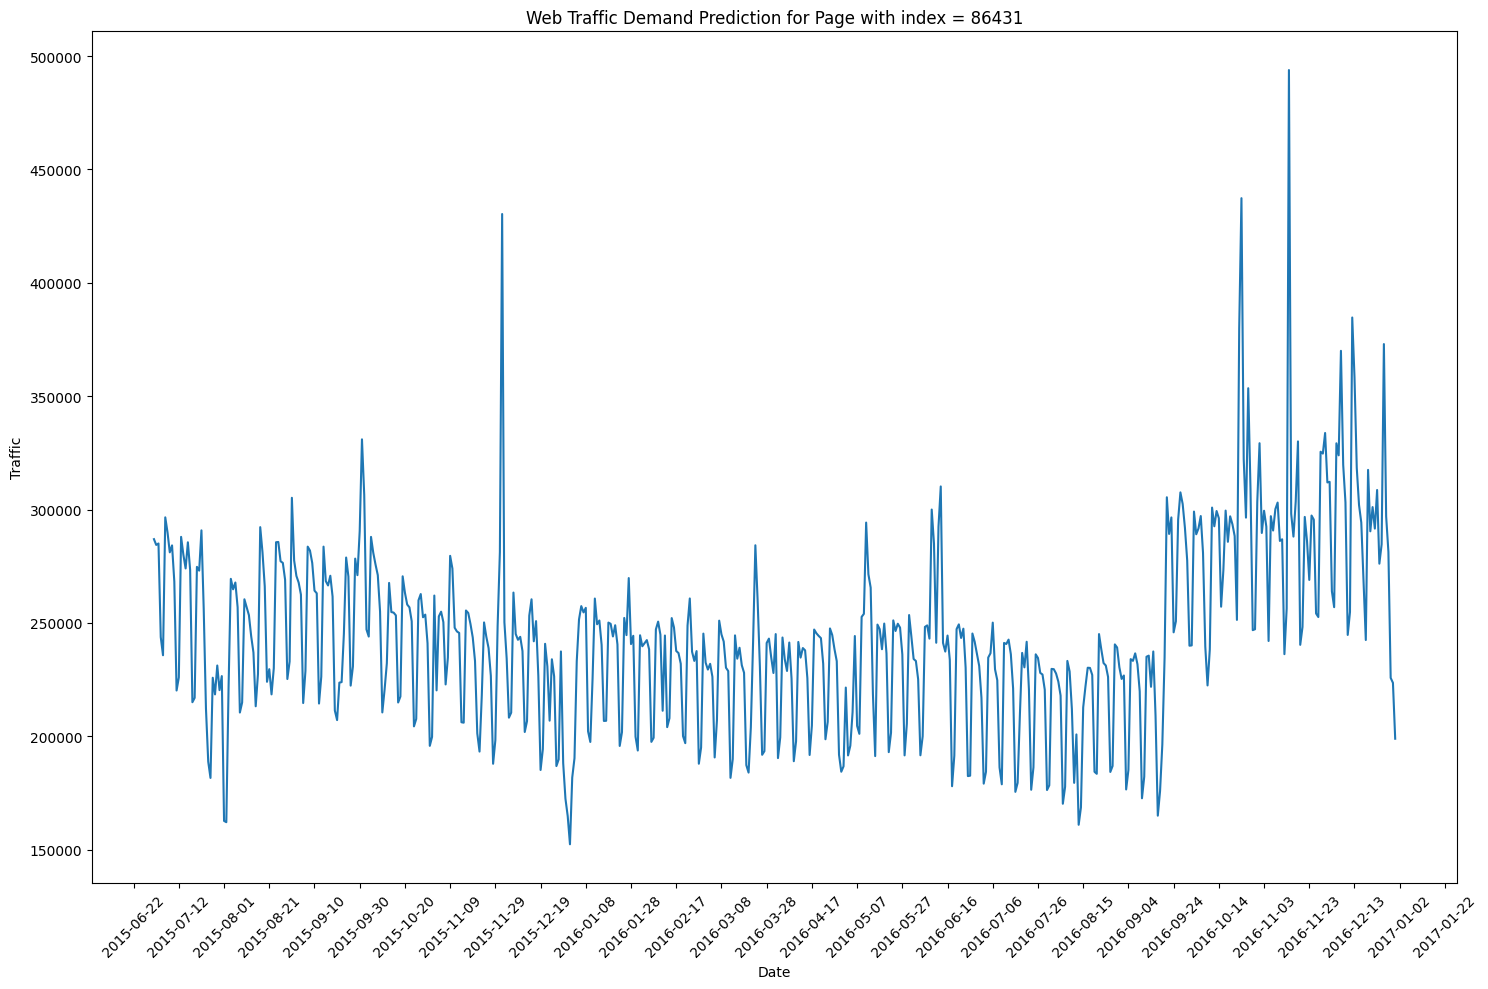

In [9]:
# Creating a DataFrame for test dates and predicted values
plot_inspection_df = pd.DataFrame({
    'Date': pd.to_datetime(date_columns),  # Dates corresponding to the test period
    'Traffic': time_serie,  # Flatten to ensure 1-dimensional
})

plt.figure(figsize=(15, 10))
plt.plot(plot_inspection_df['Date'], plot_inspection_df['Traffic'])
plt.title(f'Web Traffic Demand Prediction for Page with index = {page_index}')
plt.xlabel('Date')
plt.ylabel('Traffic')

# Set major ticks to be every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Split training and test data

In [10]:
train_data, test_data = train_test_split(time_serie, test_size=0.2, shuffle=False)

In [11]:
print(train_data.shape)
print(test_data.shape)

(440,)
(110,)


#### Split Features and Labels in Sequence Format for LSTM

In [12]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [13]:
timesteps = 3
X_train, y_train = split_sequence(train_data, n_steps=timesteps)
X_test, y_test = split_sequence(test_data, n_steps=timesteps)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(437, 3)
(437,)
(107, 3)
(107,)


In [15]:
# Split dates too
date_columns = np.array(date_columns)
train_dates = date_columns[:len(y_train)]
test_dates = date_columns[len(y_train)-3:len(y_train)-3 + len(y_test)]

In [16]:
len(test_dates)

107

#### Normalize

In [17]:
sc = MinMaxScaler()
# Save shapes for later
X_train_shape = X_train.shape[0]
X_test_shape = X_test.shape[0]

# Reshape for normalization
X_train = np.reshape(X_train,(-1,1))
y_train = np.reshape(y_train,(-1,1))

# Normalize
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

# Reshape back
n_features = 1
X_train = np.reshape(X_train, (X_train_shape, timesteps, n_features))
X_test = np.reshape(X_test, (X_test_shape, timesteps, n_features))

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(437, 3, 1)
(437, 1)
(107, 3, 1)
(107,)


# Data Modeling

Define LSTM

In [19]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(None, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/Users/marcopellegrino/miniconda3/envs/marcoenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train model on training set

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0896
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0739 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0645 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0439 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 
Epoch

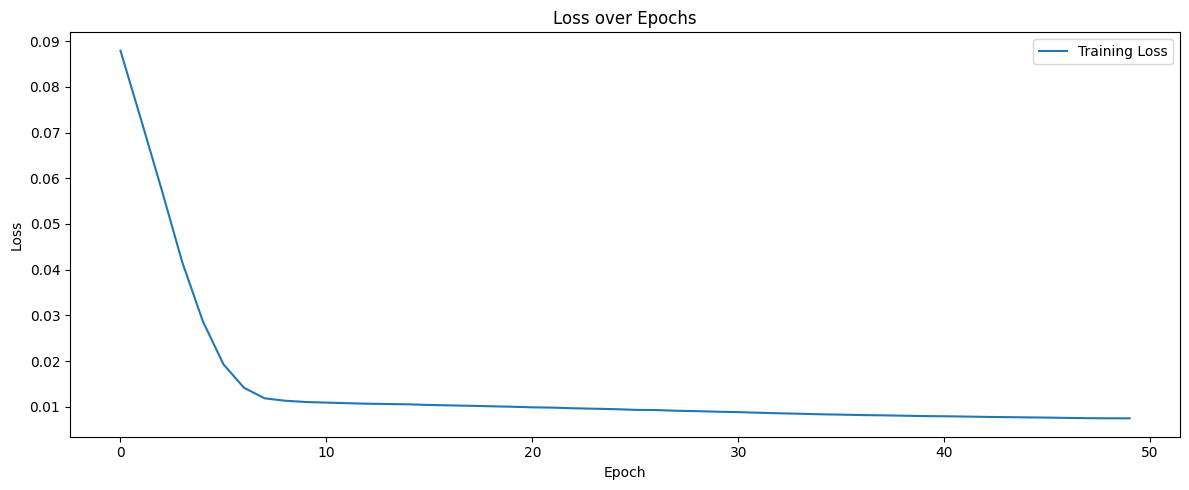

In [20]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Extract training and validation loss and accuracy from the history object
loss = history.history['loss']
val_loss = history.history.get('val_loss')
val_accuracy = history.history.get('val_accuracy')

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.plot(loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

Normalize unseen test set for prediction

In [21]:
X_test_normalized = X_test
X_test_normalized = np.reshape(X_test_normalized,(-1,1))
X_test_normalized = sc.transform(X_test_normalized)
X_test_normalized = np.reshape(X_test_normalized, (X_test_shape, timesteps, n_features))

In [22]:
len(X_test_normalized)

107

Predict

In [23]:
y_pred_normalized = model.predict(X_test_normalized)
y_pred = sc.inverse_transform(y_pred_normalized)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [24]:
len(y_pred)

107

Compute MSE metric

In [25]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2363190956.1565466


Plot observed and predicted time series

In [26]:
# Convert the date columns to datetime format
test_dates = pd.to_datetime(test_dates)

In [27]:
# Creating a DataFrame for test dates and predicted values
results_df = pd.DataFrame({
    'Date': test_dates,  # Dates corresponding to the test period
    'Actual': y_test.flatten(),  # Flatten to ensure 1-dimensional
    'Predicted': y_pred.flatten()  # Flatten to ensure 1-dimensional
})

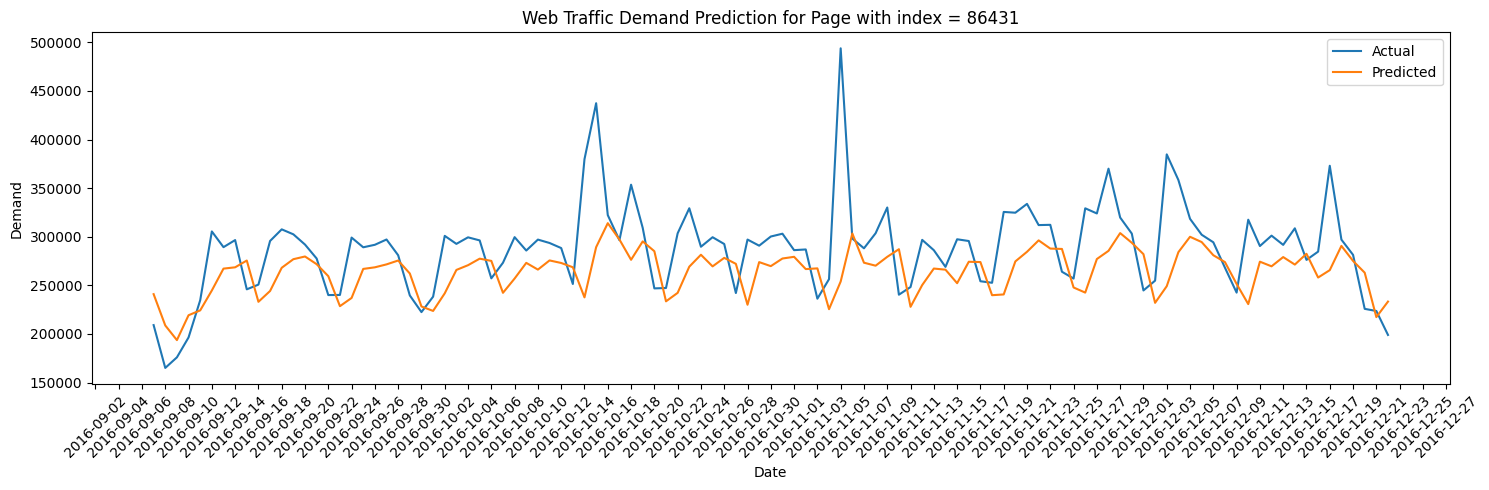

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted')
plt.title(f'Web Traffic Demand Prediction for Page with index = {page_index}')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()

# Set major ticks to be every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()